In [1]:
from uproot_io import Events, View
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt

interaction_dictionary = {}
with open('interactions.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = int(row.pop('Idx'))
        interaction = row.pop('Interaction')
        interaction_dictionary[key] = interaction
        
particle_id_dict = {-2212:"ANTIPROTON", -321:"KAON -", -211:"PION -", -13:"MUON -", -11:"ELECTRON", 0:"NO BEST MATCH", 11:"POSTIRON", 13:"MUON +", 22:"GAMMA", 211:"PION +", 321:"KAON +", 2212:"PROTON", 3112:"SIGMA -", 3222:"SIGMA +"}

In [2]:
filename="projects\CheatedRecoFile_1.root"
events = Events(filename)

In [3]:
def num_particles_in_event(num_event):
    events.event_number[num_event]
    idx = np.where(events.event_number == num_event)
    print("particles",idx[0][0],"to",idx[0][np.size(idx)-1],"in event",num_event)
#max event 9309

In [25]:
num_particles_in_event(9309)

particles 515779 to 516044 in event 9309


In [37]:
particle_id_list = [events.mc_pdg[i] for i in range(516044) if (events.reco_num_hits_w[i] > 10)]
plen = np.size(np.unique(particle_id_list))
particle_id_list= np.unique(particle_id_list,return_counts=True)
for j in range(plen):
    print(particle_id_list[1][j],particle_id_dict[particle_id_list[0][j]],end = " ;")

5 ANTIPROTON ;105 KAON - ;4321 PION - ;447 MUON - ;2762 ELECTRON ;11820 NO BEST MATCH ;3764 POSTIRON ;3385 MUON + ;9741 GAMMA ;6688 PION + ;326 KAON + ;12893 PROTON ;1 SIGMA - ;3 SIGMA + ;

In [6]:
def plot_event_particle_w(num_particle):
    hits_x_w=np.array([])
    hits_x=np.array([])
    hits_adcs=np.array([])
    for i in range(events.reco_num_hits_w[num_particle]):
        hits_x = np.append(hits_x, events.reco_hits_w[num_particle][i])
        hits_x_w = np.append(hits_x_w, events.reco_hits_x_w[num_particle][i])
        hits_adcs = np.append(hits_adcs, events.reco_adcs_w[num_particle][i])
    hits_bf = np.polyfit(hits_x,hits_x_w,1)
    hits_x_w_fit= [hits_bf[1] + i * hits_bf[0] for i in hits_x]
    #plt.plot([hits_x[0],hits_x[-1]],[hits_x_w_fit[0],hits_x_w_fit[-1]])
    plt.plot(hits_x,hits_x_w_fit)
    plt.scatter(hits_x,hits_x_w,s=8,c=hits_adcs,cmap='hot')
    
        
    
    

In [7]:
def particle_norm_w(num_particle):
    hits_x_w=np.array([])
    hits_x=np.array([])
    for i in range(events.reco_num_hits_w[num_particle]):
        hits_x = np.append(hits_x, events.reco_hits_w[num_particle][i])
        hits_x_w = np.append(hits_x_w, events.reco_hits_x_w[num_particle][i])
    hits_bf = np.polyfit(hits_x,hits_x_w,1)
    hits_x_w_fit= [i * hits_bf[0] + hits_bf[1] for i in hits_x]
    residuals = np.subtract(hits_x_w,hits_x_w_fit)
    rms = np.std(residuals)
    n_variance = np.sum(np.square(residuals))
    n_rms = rms * np.size(hits_x)
    rms_div_nhits = rms/np.size(hits_x)
    rms_div_length=rms/abs(hits_x[0]-hits_x[-1])
    return rms,n_variance,n_rms,rms_div_nhits,rms_div_length
    
    

(0.2658262421322903, 17.31257979651288, 65.12742932241112, 0.0010850050699277155, 0.0020095877562836023)
PROTON


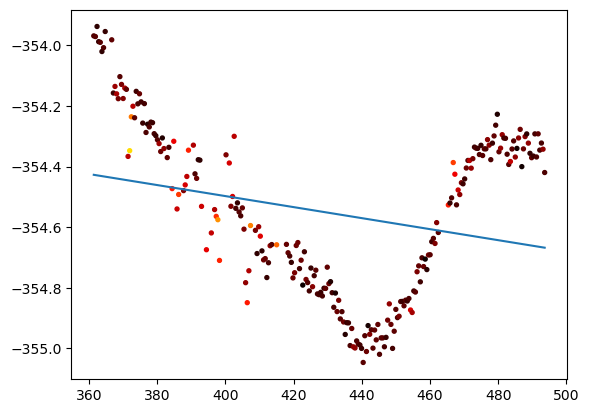

In [20]:

particle = 29

plot_event_particle_w(particle)
print(particle_norm_w(particle))

print(particle_id_dict[events.mc_pdg[particle]])
# rms has some issues compare particle 29 and 31
# rms particle 40


In [38]:
n_particles = 80000
min_hits = 15

def reco_data(metric,filtering): 
    particle_norms = [particle_norm_w(i)[metric] for i in range(n_particles) if (events.reco_num_hits_w[i] > min_hits) and (events.purity[i]>0.8)]
    particle_id = [events.mc_pdg[i] for i in range(n_particles) if (events.reco_num_hits_w[i] > min_hits) and (events.purity[i]>0.8)]
    p_data = np.dstack((particle_norms,particle_id))[0]
    #sorting data
    p_data = p_data[p_data[:, 0].argsort()]
    
    # particle filtering
    if filtering == True:
        mean = np.mean(particle_norms)
        std = np.std(particle_norms)
        #print(mean,std)
        sensitivity=[mean+4.0*std,mean+1.8*std,mean+4*std,mean+8*std,mean+8*std]
        for i in range(np.size(particle_norms)):
            if p_data[i][0] > sensitivity[metric]:
                p_data = p_data[:i]
                break
    
    # bins in histogram    
    bins = 10
    bins_array = [(i/bins)*(p_data.max(axis=0)[0]) for i in range(bins+1)]
    k = 0
    for i in range(1,bins+1):
        particle_type = np.array([])
        p_norm = np.array([])
        while p_data[k][0] < bins_array[i]:
            particle_type = np.append(particle_type,p_data[k][1])
            p_norm = np.append(p_norm,p_data[k][0])
            k = k + 1
        if k == np.size(np.concatenate(np.hsplit(p_data,2)[0])) - 1 :
            particle_type = np.append(particle_type,p_data[k][1])
            p_norm = np.append(p_norm,p_data[k][0])
            
        npart = np.size(particle_type)    
        plen = np.size(np.unique(particle_type))
        particle_type = np.unique(particle_type,return_counts=True)
        print("In Bin",i,"there are",npart,"particles which are:")
        for j in range(plen):
            print(particle_type[1][j],particle_id_dict[particle_type[0][j]],end = " ;")
        print("\n")
    
    plt.hist(np.concatenate(np.hsplit(p_data,2)[0]),bins_array)

In Bin 1 there are 3781 particles which are:
1 ANTIPROTON ;12 KAON - ;563 PION - ;53 MUON - ;111 ELECTRON ;30 POSTIRON ;397 MUON + ;119 GAMMA ;874 PION + ;43 KAON + ;1578 PROTON ;

In Bin 2 there are 644 particles which are:
1 KAON - ;33 PION - ;13 MUON - ;70 ELECTRON ;31 POSTIRON ;167 MUON + ;252 GAMMA ;73 PION + ;1 KAON + ;3 PROTON ;

In Bin 3 there are 490 particles which are:
2 KAON - ;7 PION - ;2 MUON - ;44 ELECTRON ;62 POSTIRON ;57 MUON + ;300 GAMMA ;15 PION + ;1 PROTON ;

In Bin 4 there are 444 particles which are:
8 PION - ;1 MUON - ;34 ELECTRON ;106 POSTIRON ;25 MUON + ;261 GAMMA ;8 PION + ;1 KAON + ;

In Bin 5 there are 294 particles which are:
13 ELECTRON ;91 POSTIRON ;8 MUON + ;179 GAMMA ;3 PION + ;

In Bin 6 there are 177 particles which are:
12 ELECTRON ;42 POSTIRON ;2 MUON + ;119 GAMMA ;1 PION + ;1 PROTON ;

In Bin 7 there are 59 particles which are:
4 ELECTRON ;16 POSTIRON ;1 MUON + ;37 GAMMA ;1 PION + ;

In Bin 8 there are 45 particles which are:
1 PION - ;4 ELECTRON ;

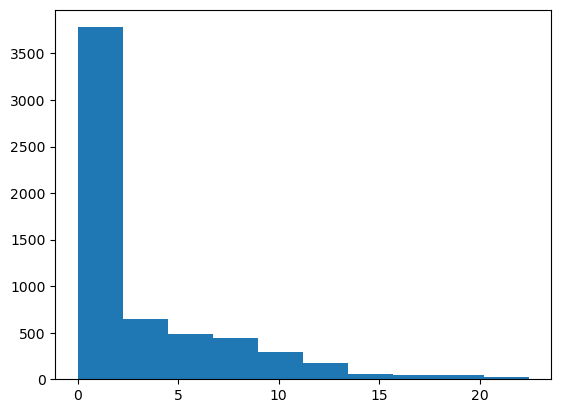

In [39]:
#plot_reco_data(metric,filtering) plots a histogram of the particles with the following metric.
#Filtering = True filters data.
#metric = 0 is rms; metric = 1 is n*variance; metric = 2 is n*rms; metric = 3 is rms/nhits; metric = 4 is rms/length
reco_data(0,True)

In Bin 1 there are 5068 particles which are:
1 ANTIPROTON ;15 KAON - ;610 PION - ;64 MUON - ;284 ELECTRON ;104 POSTIRON ;502 MUON + ;887 GAMMA ;973 PION + ;45 KAON + ;1583 PROTON ;

In Bin 2 there are 320 particles which are:
2 PION - ;2 MUON - ;6 ELECTRON ;40 POSTIRON ;66 MUON + ;202 GAMMA ;2 PION + ;

In Bin 3 there are 166 particles which are:
1 PION - ;1 MUON - ;1 ELECTRON ;32 POSTIRON ;29 MUON + ;102 GAMMA ;

In Bin 4 there are 96 particles which are:
2 ELECTRON ;30 POSTIRON ;14 MUON + ;48 GAMMA ;2 PION + ;

In Bin 5 there are 69 particles which are:
3 ELECTRON ;26 POSTIRON ;7 MUON + ;33 GAMMA ;

In Bin 6 there are 58 particles which are:
1 MUON - ;1 ELECTRON ;24 POSTIRON ;8 MUON + ;24 GAMMA ;

In Bin 7 there are 37 particles which are:
1 ELECTRON ;18 POSTIRON ;4 MUON + ;14 GAMMA ;

In Bin 8 there are 45 particles which are:
1 ELECTRON ;22 POSTIRON ;7 MUON + ;15 GAMMA ;

In Bin 9 there are 25 particles which are:
15 POSTIRON ;5 MUON + ;4 GAMMA ;1 PION + ;

In Bin 10 there are 21 p

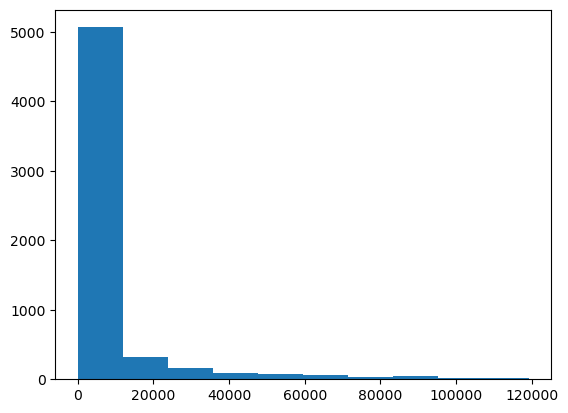

In [40]:
reco_data(1,True)